# Amazon Reviews

Group 18 Members:

- Clara Pichler, 11917694
- Hannah Knapp, 11901857 
- Sibel Toprakkiran, 09426341

### Overview

1. Introduction
- Requirements & Dependencies
- Loading in the Data Sets

2. Preprocessing

3. Classification
- SVM
- Random Forest
- Multilayer Perceptron

4. Analysis of Performance

## Introduction


### Requirements & Dependencies

This project was created using Python 3.12.5 The exact versions of the dependencies can be installed with the following command.

In [6]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from tpot import TPOTClassifier

### Loading in the Data Set

In [8]:
df_reviews = pd.read_csv('data/amazon_review_ID.shuf.lrn.csv')

## Preprocessing

The data set has 750 entries and 1002 atttributes, where the `Class` attribute is the only column with type object and has 50 unique values. 


In [9]:
display(df_reviews.info())
reviews_classes = df_reviews['Class'].unique()
print(reviews_classes, len(reviews_classes))
display(df_reviews.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Columns: 10002 entries, ID to Class
dtypes: int64(10001), object(1)
memory usage: 57.2+ MB


None

['Shea' 'Riley' 'Chachra' 'Agresti' 'Nigam' 'Messick' 'Cutey' 'Mitchell'
 'Ashbacher' 'Brody' 'Vernon' 'Goonan' 'Harp' 'Lovitt' 'Corn' 'Engineer'
 'Calvinnme' 'Chell' 'Comdet' 'Kolln' 'Peterson' 'Dent' 'Wilson' 'Mark'
 'Grove' 'Janson' 'Brown' 'Auken' 'Sherwin' 'Cholette' 'McKee' 'Taylor'
 'Walters' 'Merritt' 'Blankenship' 'Chandler' 'Johnson' 'Hayes' 'Koenig'
 'CFH' 'Lawyeraau' 'Davisson' 'Mahlers2nd' 'Power' 'Robert' 'Morrison'
 'Lee' 'Neal' 'Bukowsky' 'Vision'] 50


,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9991,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000
count,750.00000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,374.50000,11.612000,7.317333,6.724000,6.385333,6.169333,4.561333,3.981333,3.562667,2.949333,...,0.170667,0.209333,0.208000,0.232000,0.201333,0.225333,0.190667,0.208000,0.208000,0.216000
std,216.65064,5.424576,3.521150,3.330457,3.698164,3.299370,2.832361,4.069119,2.332952,2.183833,...,0.506506,0.604980,0.503064,0.764388,0.545155,0.504874,0.458905,0.489614,0.470139,0.581201
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,187.25000,8.000000,5.000000,4.000000,4.000000,4.000000,2.000000,1.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,374.50000,11.000000,7.000000,6.000000,6.000000,6.000000,4.000000,3.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,561.75000,15.000000,9.750000,9.000000,9.000000,8.000000,6.000000,6.000000,5.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,749.00000,32.000000,19.000000,20.000000,20.000000,21.000000,15.000000,21.000000,14.000000,13.000000,...,4.000000,5.000000,4.000000,8.000000,5.000000,3.000000,3.000000,4.000000,3.000000,4.000000


The following code shows that we have no missing values.

In [10]:
df_reviews.isna().sum().loc[lambda x: x>0]

Series([], dtype: int64)

For outliers one can choose among different techniques, however, since we have over 10.000 attributes we will consider IQR (interquartile range) and also z-score as comparison.

In [11]:
df_reviews_num = df_reviews.drop(['ID', 'Class'], axis=1)
Q1_rev = df_reviews_num.quantile(0.25)
Q3_rev = df_reviews_num.quantile(0.75)
IQR_rev = Q3_rev - Q1_rev

IQR_outliers_rev = df_reviews_num[((df_reviews_num < (Q1_rev - 1.5 * IQR_rev)) | (df_reviews_num > (Q3_rev + 1.5 * IQR_rev))).any(axis=1)]
display(IQR_outliers_rev.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Columns: 10000 entries, V1 to V10000
dtypes: int64(10000)
memory usage: 57.2 MB


None

In [12]:
z_scores_rev = stats.zscore(df_reviews_num)
abs_z_scores_rev = np.abs(z_scores_rev)
filtered_entries_rev = (abs_z_scores_rev < 3).all(axis=1)

df_reviews_Z = df_reviews[filtered_entries_rev].copy()
display(df_reviews_Z.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 10002 columns):
 #      Column  Dtype 
---     ------  ----- 
 0      ID      int64 
 1      V1      int64 
 2      V2      int64 
 3      V3      int64 
 4      V4      int64 
 5      V5      int64 
 6      V6      int64 
 7      V7      int64 
 8      V8      int64 
 9      V9      int64 
 10     V10     int64 
 11     V11     int64 
 12     V12     int64 
 13     V13     int64 
 14     V14     int64 
 15     V15     int64 
 16     V16     int64 
 17     V17     int64 
 18     V18     int64 
 19     V19     int64 
 20     V20     int64 
 21     V21     int64 
 22     V22     int64 
 23     V23     int64 
 24     V24     int64 
 25     V25     int64 
 26     V26     int64 
 27     V27     int64 
 28     V28     int64 
 29     V29     int64 
 30     V30     int64 
 31     V31     int64 
 32     V32     int64 
 33     V33     int64 
 34     V34     int64 
 35     V35     int64 
 36     V36     int64 
 37     V37 

None

Both methods classified every entry as outlier. This can happen when working with such a data set which has so many features.  In high-dimensional spaces, distances between points can be less meaningful, _curse of dimensionality_, which can cause distance-based metrics like z-scores to produce extreme values. Additionally, if our data is highly skewed in any column, this can make typical IQR and z-score thresholds capture too many points as outliers.

In this instance, a data set with 10002 feature and only 750 entries, performing feature selection makes a lot of sense. It can help optimize our model, improve its performance.

In [175]:
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=100, step=10)
rfe.fit(df_reviews_num, df_reviews['Class'])
selected_features = df_reviews_num.columns[rfe.support_]
df_rev_rfe = df_reviews[selected_features].copy()
df_rev_rfe['Class'] = df_reviews['Class'].values

In [176]:
model_k = SelectKBest(score_func=chi2, k=100)
model_k.fit(df_reviews_num, df_reviews['Class'])
selected_features_k = df_reviews_num.columns[model_k.get_support()]

df_rev_k = df_reviews[selected_features_k].copy()
df_rev_k['Class'] = df_reviews['Class'].values

In [177]:
df_reviews_num_rfe = df_rev_rfe.drop(['Class'], axis=1)
Q1_rev = df_reviews_num_rfe.quantile(0.25)
Q3_rev = df_reviews_num_rfe.quantile(0.75)
IQR_rev = Q3_rev - Q1_rev

df_rev_rfe_IQR = df_rev_rfe[~((df_reviews_num_rfe < (Q1_rev - 1.5 * IQR_rev)) | (df_reviews_num_rfe > (Q3_rev + 1.5 * IQR_rev))).any(axis=1)]
display(df_rev_rfe_IQR.info())

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 8 to 745
Columns: 101 entries, V1 to Class
dtypes: int64(100), object(1)
memory usage: 115.5+ KB


None

## Classification

In [13]:
df_reviews_test = pd.read_csv('data/amazon_review_ID.shuf.tes.csv')
X_test_final = df_reviews_test.drop(['ID'], axis=1)

In [14]:
def create_test_train(df):
    X_rev = df_reviews.drop(['ID', 'Class'], axis=1)
    y_rev = df_reviews['Class']
    return train_test_split(X_rev,y_rev, random_state=104, test_size=0.25, shuffle=True, stratify=y_rev)

X_rev_train, X_rev_test, y_rev_train, y_rev_test = create_test_train(df_reviews)
# X_rev_train, X_rev_test, y_rev_train, y_rev_test = create_test_train(df_rev_rfe)
# X_rev_train, X_rev_test, y_rev_train, y_rev_test = create_test_train(df_rev_rfe_IQR)
# X_rev_train, X_rev_test, y_rev_train, y_rev_test = create_test_train(df_rev_k)

One probelm we might face is that not every class is represented in the test set. We added `stratify=y_rev`. This parameter ensures that the split is stratified according to the labels in y_rev, meaning each subset (training and testing) will have the same proportion of each class as in the original dataset.

In [219]:
display(len(y_rev_test.unique()))

50

In [220]:
def evaluate_classification(model, X_test, y_test):
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy * 100))
    print('Classification Report:')
    print(classification_report(y_test, predictions, zero_division=1))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions))
    
    return accuracy

In [221]:
def to_csv_file(predictions, df_test, name):
    df_predictions = pd.DataFrame({'ID': df_test['ID'], 'Class': predictions})
    path = 'predictions/' + name + '_predictions.csv'
    df_predictions.to_csv(path, index=False)


### Support Vector Machines

In [192]:
params_grid_svm = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 0.1], 'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
    {'kernel': ['poly'], 'degree': [2, 3], 'C': [1, 10, 100, 1000]}
]

svm_model = GridSearchCV(SVC(), params_grid_svm, cv=5, scoring='accuracy')

In [193]:
svm_model.fit(X_rev_train, y_rev_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.001, 0.0001, 0.1], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [194]:
print("Best parameter: ", svm_model.best_params_,"\n")
print('Best score for training data:', svm_model.best_score_,"\n") 
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

best_model_svm = svm_model.best_estimator_

Best parameter:  {'C': 1, 'kernel': 'linear'} 

Best score for training data: 0.421634007585335 

Best C: 1 

Best Kernel: linear 

Best Gamma: scale 



In [118]:
svm_rev_accuracy = evaluate_classification(svm_model, X_rev_test, y_rev_test)
svm_rev_accuracy_best = evaluate_classification(best_model_svm, X_rev_test, y_rev_test)

print('Improvement of {:0.2f}%.'.format( 100 * (svm_rev_accuracy_best - svm_rev_accuracy) / svm_rev_accuracy))

Model Performance
Accuracy = 50.53%.
Classification Report:
              precision    recall  f1-score   support

     Agresti       0.33      0.25      0.29         4
   Ashbacher       1.00      0.67      0.80         3
       Auken       0.50      0.67      0.57         3
 Blankenship       1.00      0.50      0.67         4
       Brody       0.33      0.75      0.46         4
       Brown       0.00      0.00      0.00         4
    Bukowsky       0.75      0.75      0.75         4
         CFH       1.00      0.75      0.86         4
   Calvinnme       0.33      0.25      0.29         4
     Chachra       0.38      0.60      0.46         5
    Chandler       0.50      0.50      0.50         4
       Chell       0.50      0.80      0.62         5
    Cholette       0.50      0.25      0.33         4
      Comdet       0.43      0.60      0.50         5
        Corn       0.50      0.50      0.50         4
       Cutey       0.75      0.75      0.75         4
    Davisson       0.

In [195]:
y_pred_svm = best_model_svm.predict(X_test_final)

# to_csv_file(y_pred_svm, df_reviews_test, "reviews_SVM")
to_csv_file(y_pred_svm, df_reviews_test, "reviews_SVM_rfe")
# to_csv_file(y_pred_svm, df_reviews_test, "reviews_SVM_k")
# to_csv_file(y_pred_svm, df_reviews_test, "reviews_SVM_rfe_IQR")

### Random Forest

In [203]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_rev_train, y_rev_train)

RandomForestClassifier(random_state=42)

In [204]:
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [205]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['log2', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}


In [206]:
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
rf_random.fit(X_rev_train, y_rev_train)

/Users/clarapichler/Documents/Projects/myenv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [207]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_rev_train, y_rev_train)
base_accuracy = evaluate_classification(rf_model, X_rev_test, y_rev_test)
    
best_model_rf = rf_random.best_estimator_

random_accuracy = evaluate_classification(best_model_rf,X_rev_test, y_rev_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 61.17%.
Classification Report:
              precision    recall  f1-score   support

     Agresti       0.40      0.50      0.44         4
   Ashbacher       0.50      0.67      0.57         3
       Auken       0.50      0.33      0.40         3
 Blankenship       1.00      1.00      1.00         4
       Brody       0.43      0.75      0.55         4
       Brown       0.33      0.75      0.46         4
    Bukowsky       0.30      0.75      0.43         4
         CFH       0.75      0.75      0.75         4
   Calvinnme       0.67      0.50      0.57         4
     Chachra       0.36      0.80      0.50         5
    Chandler       0.57      1.00      0.73         4
       Chell       0.67      0.40      0.50         5
    Cholette       0.67      0.50      0.57         4
      Comdet       0.40      0.40      0.40         5
        Corn       0.67      0.50      0.57         4
       Cutey       0.57      1.00      0.73         4
    Davisson       0.

In [208]:
y_pred = best_model_rf.predict(X_test_final)

# to_csv_file(y_pred, df_reviews_test, "reviews_RF")
# to_csv_file(y_pred_svm, df_reviews_test, "reviews_RF_rfe")
to_csv_file(y_pred_svm, df_reviews_test, "reviews_RF_rfe_IQR")
# to_csv_file(y_pred_svm, df_reviews_test, "reviews_RF_k")

### Multilayer Perceptron

## TPOT

In [15]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=120, max_eval_time_mins=2, population_size=40)
tpot.fit(X_rev_train, y_rev_train)

Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5533185840707964

Generation 2 - Current best internal CV score: 0.6618362831858408

Generation 3 - Current best internal CV score: 0.6618362831858408


: 

In [ ]:
tpot.score(X_rev_test, y_rev_test)
tpot.export('tpot/tpot_reviews_pipeline.py')

_________________________________

# Feature Selection

In a scenario with many features and limited samples, performing feature selection makes a lot of sense. It can help optimize our model, improve its performance.

In [5]:
X = df_reviews.drop(['ID', 'Class'], axis=1)
y = df_reviews['Class']
# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X (features):", X_train.shape)
print("Shape of y (target):", y_train.shape)

Shape of X (features): (600, 10000)
Shape of y (target): (600,)


# Univariate Selection:
statistical tests (like Chi-squared tests for categorical data or F-tests for continuous variables) to select features with the strongest relationship to the target variable.

In [6]:
from sklearn.feature_selection import SelectKBest, chi2

# Choose the top k features based on univariate statistical tests
# We don't have I think categorical data so not sure if we should use this???
selector = SelectKBest(score_func=chi2, k=100) 
X_new = selector.fit_transform(X_train, y_train)
X_new.shape

(600, 100)

In [32]:
# Identify constant features
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]
constant_features
# Drop constant features
X_train = X_train.drop(columns=constant_features)
print(f"Removed constant features: {constant_features}")

Removed constant features: []


In [34]:
# Check for NaN values
print(X_train.isnull().sum())

# Check for infinite values
print(np.isinf(X_train).sum())

V1        0
V2        0
V3        0
V4        0
V5        0
         ..
V9996     0
V9997     0
V9998     0
V9999     0
V10000    0
Length: 10000, dtype: int64
V1        0
V2        0
V3        0
V4        0
V5        0
         ..
V9996     0
V9997     0
V9998     0
V9999     0
V10000    0
Length: 10000, dtype: int64


In [45]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with variance below a certain threshold
sel = VarianceThreshold(threshold=0.05)
X_train_filtered = sel.fit_transform(X_train)
print(X_train_filtered)

# Get the columns that were retained
retained_columns = X_train.columns[sel.get_support()]
X_train_filtered = pd.DataFrame(X_train_filtered, columns=retained_columns)

[[17  4  8 ...  0  1  1]
 [21  9  5 ...  0  1  0]
 [ 9  7  6 ...  0  1  1]
 ...
 [13  8  6 ...  1  0  0]
 [14 16  7 ...  0  0  0]
 [12 11  7 ...  0  0  0]]


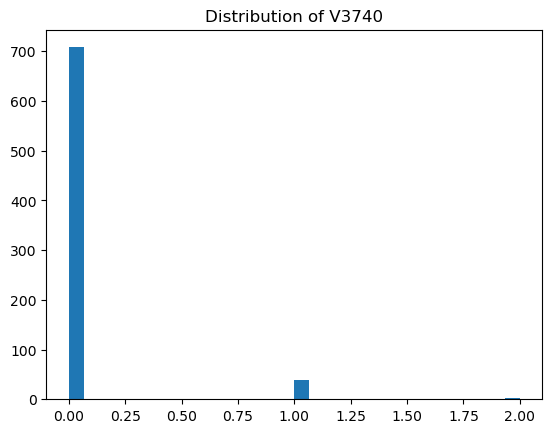

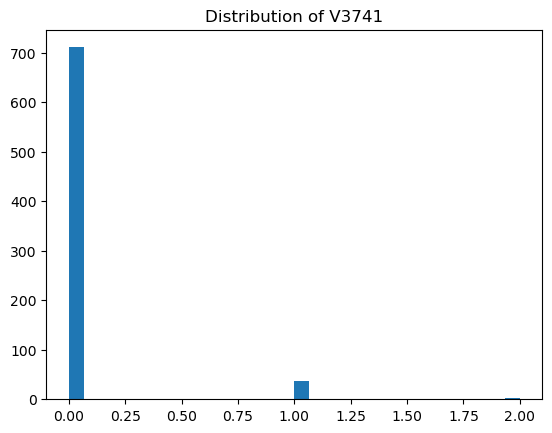

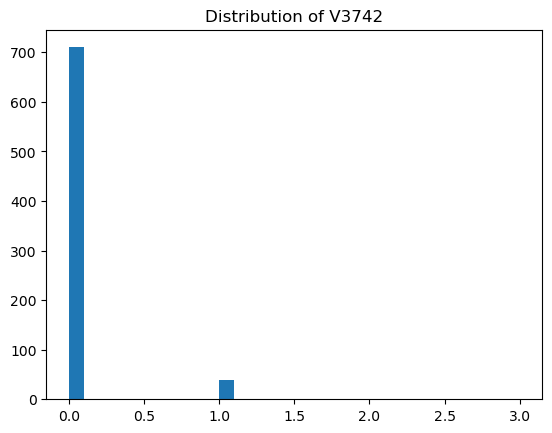

In [47]:
import matplotlib.pyplot as plt

# Plot distribution of a few features
for column in X_train_filtered.columns[1000:1003]:
    plt.hist(X_train[column], bins=30)
    plt.title(f'Distribution of {column}')
    plt.show()

# Recursive Feature Elimination (RFE):
This method recursively removes the least important features based on the model's performance until the specified number of features is reached.

In [17]:
from sklearn.feature_selection import RFE

model = RandomForestClassifier(random_state=42)


In [ ]:
#############!!!! runs very long !!!!! #################
rfe = RFE(model, n_features_to_select=100)  
X_rfe = rfe.fit_transform(X, y)

# Feature Importance from Tree-based Models:
Models like Random Forest or Gradient Boosting provide feature importance scores which can be used to select the top features.

In [18]:
model.fit(X, y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top features
X_selected = X_train.iloc[:, indices[:100]] 
X_selected

,V6629,V6924,V1379,V1405,V4377,V6707,V6597,V1381,V6793,V4380,...,V6581,V12,V6576,V6636,V6616,V106,V2,V4426,V7009,V5389
0,5,1,0,0,0,6,16,0,1,0,...,19,0,26,4,11,0,4,0,2,0
1,7,1,0,0,0,0,10,0,2,0,...,46,3,27,9,5,0,9,0,1,0
2,6,1,0,0,0,0,7,0,2,0,...,24,2,28,5,5,0,7,0,0,0
3,21,1,0,0,0,11,12,0,3,0,...,18,2,30,3,8,0,3,0,1,0
4,13,0,0,0,0,2,3,0,0,0,...,28,2,32,8,12,0,8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,3,1,0,0,0,5,7,0,1,0,...,19,5,38,1,3,4,1,0,0,0
746,12,0,0,0,0,5,19,0,0,0,...,29,0,67,6,13,0,7,0,1,0
747,5,2,0,0,0,6,17,0,3,0,...,16,6,28,8,11,0,8,0,2,0
748,9,0,0,0,0,6,3,0,0,0,...,44,10,28,15,15,0,16,0,8,0


# Principal Component Analysis (PCA)
If we want to reduce dimensionality while retaining variance, PCA can be a good choice. It transforms the features into a set of linear combinations.

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)  
X_pca = pca.fit_transform(X_train)
X_pca.shape

(750, 100)

# Which machine learning algorithm should we choose
Random Forest or XGBoost can handle high-dimensional data effectively. 
 We could also try other models like SVM or neural networks, but there is a risk of overfitting given the dataset's size.

## RandomForestClassifier

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [13]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Work\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Work\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Work\anaconda\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Work\anaconda\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Work\anaconda\Lib\site-packages\sklearn\utils\_param_validation.py", 

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_classification(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy * 100))
    print('Classification Report:')
    print(classification_report(test_labels, predictions))
    print('Confusion Matrix:')
    print(confusion_matrix(test_labels, predictions))
    
    return accuracy
    
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate_classification(base_model, X_test, y_test)
    
best_random = rf_random.best_estimator_

random_accuracy = evaluate_classification(best_random,X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Accuracy = 56.00%.
Classification Report:
              precision    recall  f1-score   support

     Agresti       0.33      1.00      0.50         1
   Ashbacher       0.50      0.50      0.50         2
       Auken       1.00      0.50      0.67         2
 Blankenship       1.00      1.00      1.00         5
       Brody       0.60      1.00      0.75         3
       Brown       0.50      0.33      0.40         3
    Bukowsky       0.50      0.67      0.57         3
         CFH       1.00      0.40      0.57         5
   Calvinnme       0.40      0.67      0.50         3
     Chachra       0.80      0.57      0.67         7
    Chandler       0.44      1.00      0.62         4
       Chell       0.33      0.75      0.46         4
    Cholette       0.00      0.00      0.00         3
      Comdet       0.50      0.50      0.50         4
        Corn       0.20      1.00      0.33         1
       Cutey       0.67      1.00      0.80         2
    Davisson       0.

C:\Work\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Work\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Work\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Work\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:15

Model Performance
Accuracy = 74.00%.
Classification Report:
              precision    recall  f1-score   support

     Agresti       0.50      1.00      0.67         1
   Ashbacher       1.00      1.00      1.00         2
       Auken       1.00      1.00      1.00         2
 Blankenship       1.00      1.00      1.00         5
       Brody       1.00      0.67      0.80         3
       Brown       0.75      1.00      0.86         3
    Bukowsky       0.29      0.67      0.40         3
         CFH       1.00      1.00      1.00         5
   Calvinnme       0.67      0.67      0.67         3
     Chachra       0.67      0.57      0.62         7
    Chandler       0.50      1.00      0.67         4
       Chell       1.00      1.00      1.00         4
    Cholette       1.00      0.33      0.50         3
      Comdet       0.67      1.00      0.80         4
        Corn       0.50      1.00      0.67         1
       Cutey       1.00      1.00      1.00         2
    Davisson       0.

C:\Work\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Work\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Work\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
df_reviews_test = pd.read_csv('data/amazon_review_ID.shuf.tes.csv')
X_test_final = df_reviews_test.drop(['ID'], axis=1)
print("Shape of X (features):", X_test_final.shape)
y_pred = best_random.predict(X_test_final)
result_df = pd.DataFrame({'ID': df_reviews_test['ID'], '"Class"': y_pred})
result_df.head()
result_df.to_csv('amazon_review_ID.shuf.sol.ex.csv', index=False)

Shape of X (features): (750, 10000)


# SVC

In [26]:
model = SVC(kernel='linear')  # also try other kernels like 'rbf'
model.fit(X_train, y_train)

SVC(kernel='linear')